# How to train the CMS electron MVA ID with xgbo

Reading the data
-----------------

Read in the electron ntuple. These are 20000 electron entries generated by
the [ElectronMVANtuplizer](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/plugins/ElectronMVANtuplizer.cc) (example [config file](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/python/Training/ElectronMVANtuplizer_cfg.py)), converted to HDF 5 for better pandas
compatibility.

In [1]:
import pandas as pd

df = pd.read_hdf("../res/electron_data.hdf")

Reading the ROOT file directly is almost equally easy, and you don't even
need to install ROOT! Just use uproot, a very leightweight python package:

```python
import uproot 

tree = uproot.open("../res/electron_data.root")["ntuplizer/tree"]
df = tree.pandas.df(branches=None, entrystop=None)
```

Setting up the training and testing samples
-------------------------------------------

First, we select the kinematic range for out training. Let's say we want to
train the ID for the endcap region (1.5 < |eta| < 2.5) above p_T > 10 GeV.

Addeitionally, we do not want to consider electrons from tau decays, which are
encoded with "matchedToGenEle == 2".

In [2]:
df = df.query("ele_pt > 10 & 1.5 < abs(scl_eta) < 2.5")
df = df.query("matchedToGenEle != 2")

Next, we need to define our feature columns. Let's include the particle flow
isolation components, and since we are in the endcap, the relative pre-shower
energy.

In [3]:
features = ["ele_oldsigmaietaieta", "ele_oldsigmaiphiiphi",
            "ele_oldcircularity", "ele_oldr9", "ele_scletawidth",
            "ele_sclphiwidth", "ele_oldhe", "ele_kfhits", "ele_kfchi2",
            "ele_gsfchi2", "ele_fbrem", "ele_gsfhits",
            "ele_expected_inner_hits", "ele_conversionVertexFitProbability",
            "ele_ep", "ele_eelepout", "ele_IoEmIop", "ele_deltaetain",
            "ele_deltaphiin", "ele_deltaetaseed", "rho",
            "ele_pfPhotonIso", "ele_pfChargedHadIso", "ele_pfNeutralHadIso",
            "ele_psEoverEraw"]

Our target variable, y, is whether the electron is matched to a true prompt
electron.

In [4]:
df.eval("y = matchedToGenEle == 1", inplace=True)

Finally, we will split up the data frame is training and testing samples, while
extracting the features and target variable.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features],
                                                    df["y"],
                                                    random_state=99,
                                                    test_size=0.25)

Let's now to a simple default xgboost training with early stopping. We have to
convert the data to xgboosts DMatrix format first.

In [ ]:
import xgboost as xgb

xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest  = xgb.DMatrix(X_test , label=y_test )

params = {'eval_metric':'auc',
          'objective'  :'binary:logitraw'}
model_default = xgb.train(params, xgtrain, num_boost_round=1000)

Next we try out the xgbo package.

In [7]:
from xgbo import XgboClassifier

xgbo_classifier = XgboClassifier(out_dir="electron_id")

xgbo_classifier.optimize(xgtrain, init_points=1, n_iter=1, acq='ei')

xgbo_classifier.fit(xgtrain, model="default")
xgbo_classifier.fit(xgtrain, model="optimized")

xgbo_classifier.save_model(features, model="default")
xgbo_classifier.save_model(features, model="optimized")

Found results of 7 optimization rounds in ouptut directory, loading...
|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[0]	train-auc:0.874484+0.0051704	test-auc:0.862667+0.00927063
[10]	train-auc:0.974186+0.000565221	test-auc:0.968716+0.000442341
[20]	train-auc:0.980631+0.000400275	test-auc:0.976055+0.000316007
[30]	train-auc:0.983197+0.000266595	test-auc:0.978452+0.000212237
[40]	train-auc:0.984256+1.23648e-05	test-auc:0.979785+0.000199361
[50]	train-auc:0.985256+0.000136061	test-auc:0.980576+9.92315e-05
[60]	train-auc:0.985733+0.000168842	test-auc:0.980887+5.57634e-05
[70]	train-auc:0.986049+7.15557e-05	test-auc:0.981092+2.30988e-05
[80]	train-auc:0.986303+9.40225e-05	test-au

Now, let's make predictions with all models we got on the testing sample.

In [8]:
preds_default    = model_default.predict(xgtest)
preds_early_stop = xgbo_classifier.predict(xgtest, model="default")
preds_optimized  = xgbo_classifier.predict(xgtest, model="optimized")

Finally, we want to plot some ROC curves.

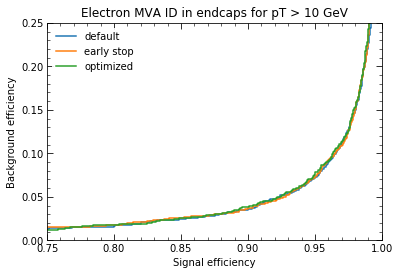

In [10]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr_default   , tpr_default, _    = metrics.roc_curve(y_test, preds_default, pos_label=1)
fpr_early_stop, tpr_early_stop, _ = metrics.roc_curve(y_test, preds_early_stop, pos_label=1)
fpr_optimized , tpr_optimized, _  = metrics.roc_curve(y_test, preds_optimized, pos_label=1)

plt.figure()
plt.plot(tpr_default, fpr_default, label='default')
plt.plot(tpr_early_stop, fpr_early_stop, label='early stop')
plt.plot(tpr_optimized, fpr_optimized, label='optimized')
plt.title("Electron MVA ID in endcaps for pT > 10 GeV")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim(0.75, 1.0)
plt.ylim(0.0, 0.25)
plt.legend(loc='upper left')
plt.show()

With this small example dataset, the hyperparameter optimization was not very effective as the statistical fluctuation of the target seems to be larger than the effect of the hyperparameters, which makes it difficult for the Bayesian optimization to converge.